## Task is to predict if customer chooses given car insurance policy.

__File descriptions__

- train.csv - the training set
- test.csv - the test set

__Data fields__
- profile_* - customer features
- car_* - car features
- policy_* or tack_* - policy features
- town_* - town features

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from tqdm.notebook import tqdm
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from BorutaShap import BorutaShap

In [15]:
# !pip install catboost
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [16]:
from catboost import CatBoostClassifier, Pool, cv

In [17]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

## 1. EDA

Размер датасета

In [18]:
df_train.shape, df_test.shape

((25441, 64), (25441, 63))

Пропуски в данных отсутствуют

In [19]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [20]:
df_train.target.value_counts()

0    19292
1     6149
Name: target, dtype: int64

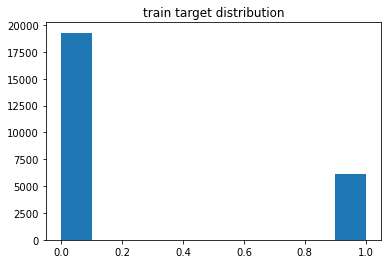

In [21]:
plt.title('train target distribution')
plt.hist(df_train.target)
plt.show()

Описание данных:

- profile_* - customer features
- car_* - car features
- policy_* or tack_* - policy features
- town_* - town features

Все признаки числовые

### 1.1. profile_* - customer features

- 'profile_age' - возраст от 18 до 75
-  'profile_town' - город, 36 городов
-  'profile_district' - район, 4773 уникальных значений
-  'profile_ismarried' - семейное положение, 1\0
-  'profile_driving_experince' - опыт вождения, только 0

In [22]:
profile_col = [col for col in df_train.columns if col.startswith('profile_')]

In [23]:
df_train[profile_col].head(4)

,profile_age,profile_town,profile_district,profile_ismarried,profile_driving_experince
0,44.0,15,577,0,0
1,52.0,20,2247,0,0
2,59.0,21,726,1,0
3,66.0,22,4082,0,0


In [24]:
df_test[profile_col].head(4)

,profile_age,profile_town,profile_district,profile_ismarried,profile_driving_experince
0,36.0,13,1051,0,0
1,75.0,23,3476,0,0
2,32.0,23,3079,0,0
3,52.0,18,2149,0,0


Статистика profile_ по трейну и тесту

In [25]:
df_train[profile_col].describe()

,profile_age,profile_town,profile_district,profile_ismarried,profile_driving_experince
count,25441.000000,25441.000000,25441.000000,25441.000000,25441.0
mean,44.852757,11.086475,1898.861680,0.164420,0.0
std,17.307711,7.981582,1313.333932,0.370663,0.0
min,18.000000,0.000000,0.000000,0.000000,0.0
25%,28.000000,4.000000,765.000000,0.000000,0.0
50%,44.000000,9.000000,1713.000000,0.000000,0.0
75%,59.000000,16.000000,2868.000000,0.000000,0.0
max,75.000000,35.000000,5315.000000,1.000000,0.0


In [26]:
df_test[profile_col].describe()

,profile_age,profile_town,profile_district,profile_ismarried,profile_driving_experince
count,25441.000000,25441.000000,25441.000000,25441.000000,25441.0
mean,44.859793,11.100232,1901.360520,0.166621,0.0
std,17.313170,7.960220,1311.777967,0.372644,0.0
min,18.000000,0.000000,0.000000,0.000000,0.0
25%,28.000000,4.000000,777.000000,0.000000,0.0
50%,44.000000,10.000000,1692.000000,0.000000,0.0
75%,59.000000,16.000000,2875.000000,0.000000,0.0
max,75.000000,35.000000,5314.000000,1.000000,0.0


Распределение profile_. Показатель profile_driving_experience не имеет смысла, т.к. содержит только 0.

Трейн

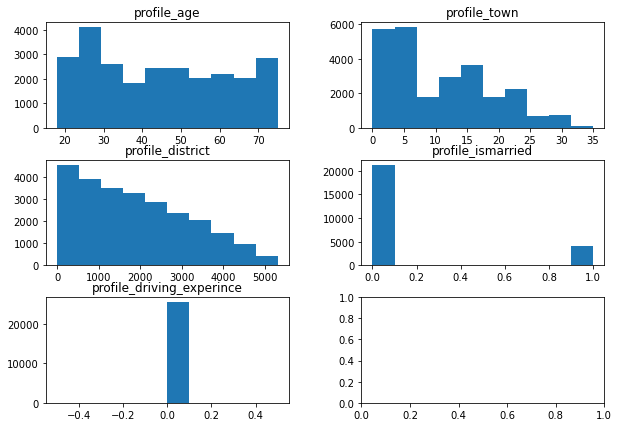

In [27]:
fig, axs = plt.subplots(3,2, figsize=(10, 7))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

axs = axs.ravel()

for i,j  in enumerate(df_train[profile_col].columns):
        axs[i].hist(df_train[j])
        axs[i].set_title(str(j))

Тест

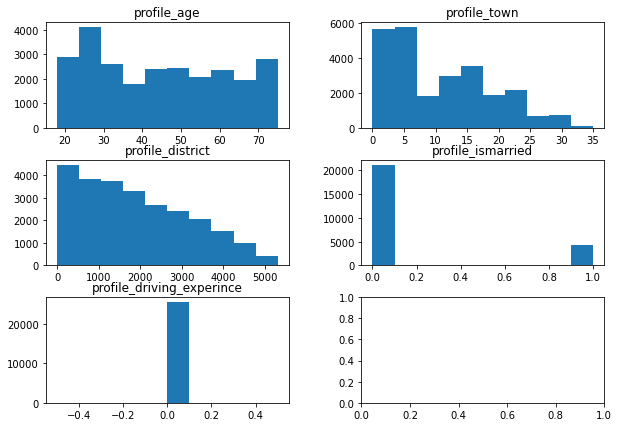

In [28]:
fig, axs = plt.subplots(3,2, figsize=(10, 7))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

axs = axs.ravel()

for i,j  in enumerate(df_test[profile_col].columns):
        axs[i].hist(df_test[j])
        axs[i].set_title(str(j))

Признаки между собой не скоррелированы

<AxesSubplot:>

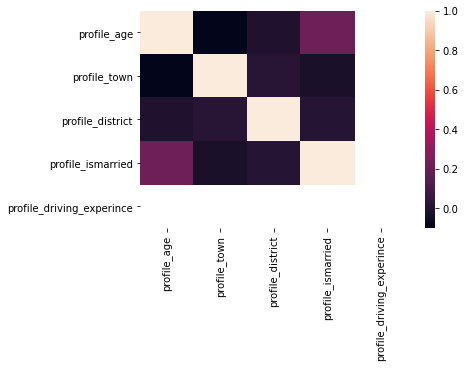

In [29]:
sns.heatmap(df_train[profile_col].corr())

<AxesSubplot:>

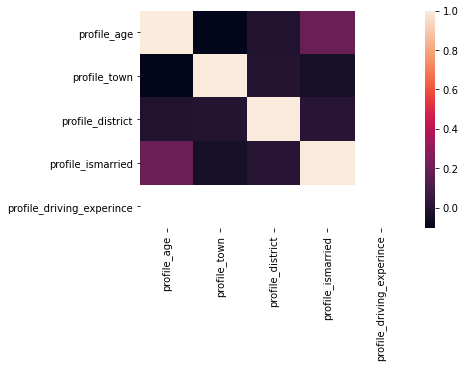

In [30]:
sns.heatmap(df_test[profile_col].corr())

Посмотрим на то, как признаки связаны с целевой переменной

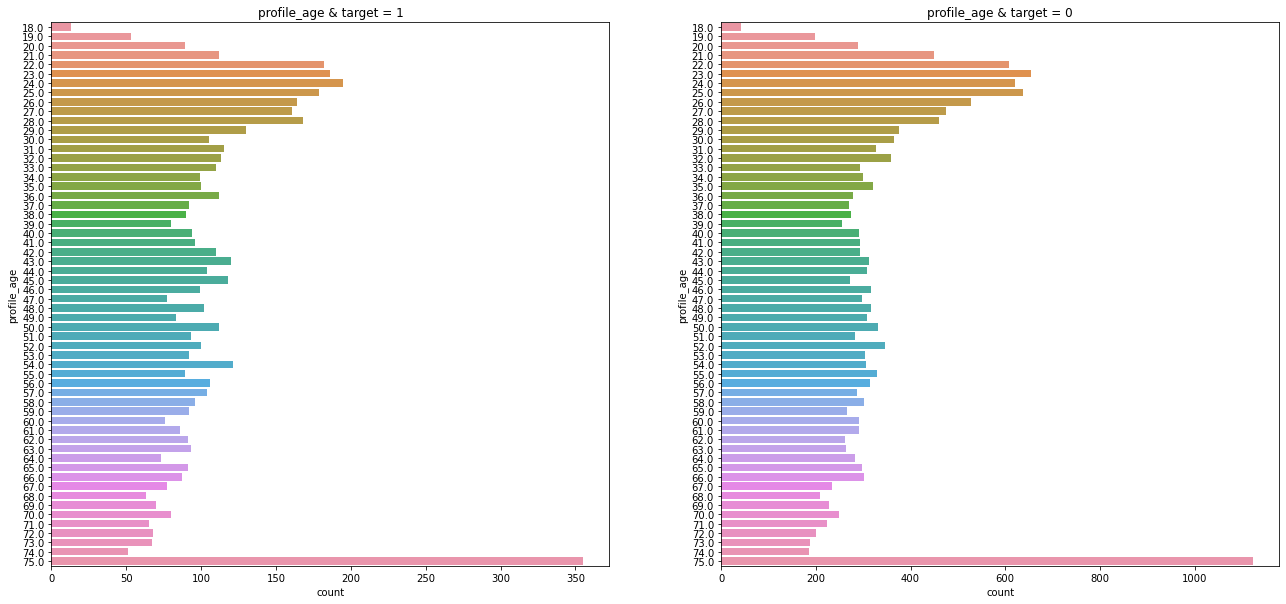

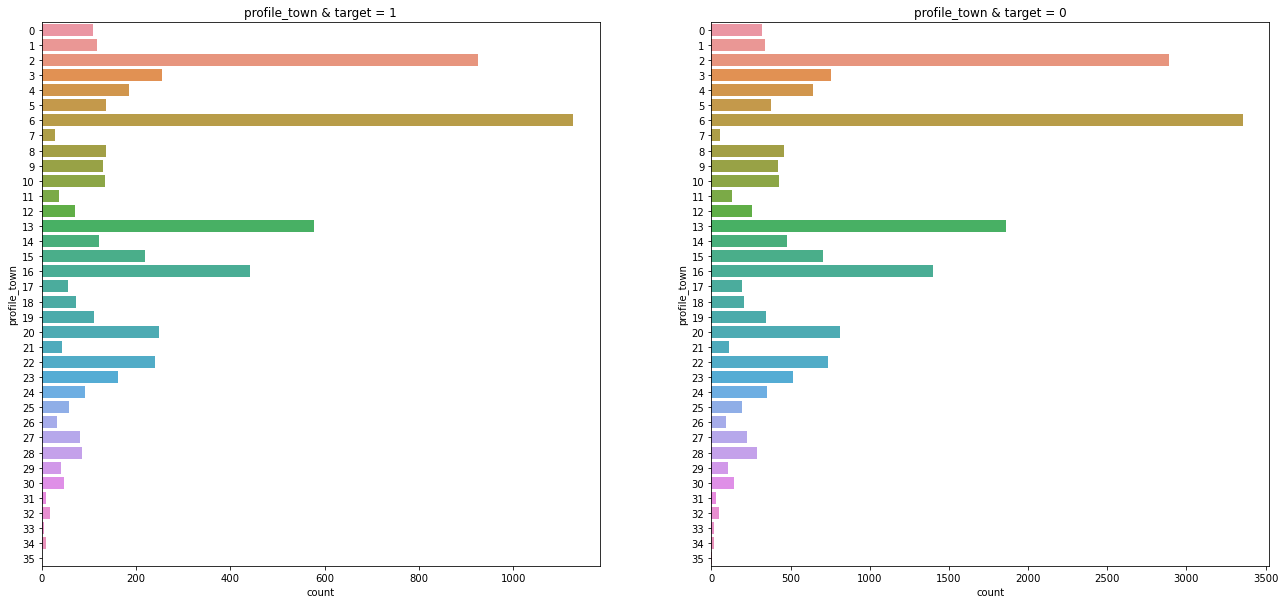

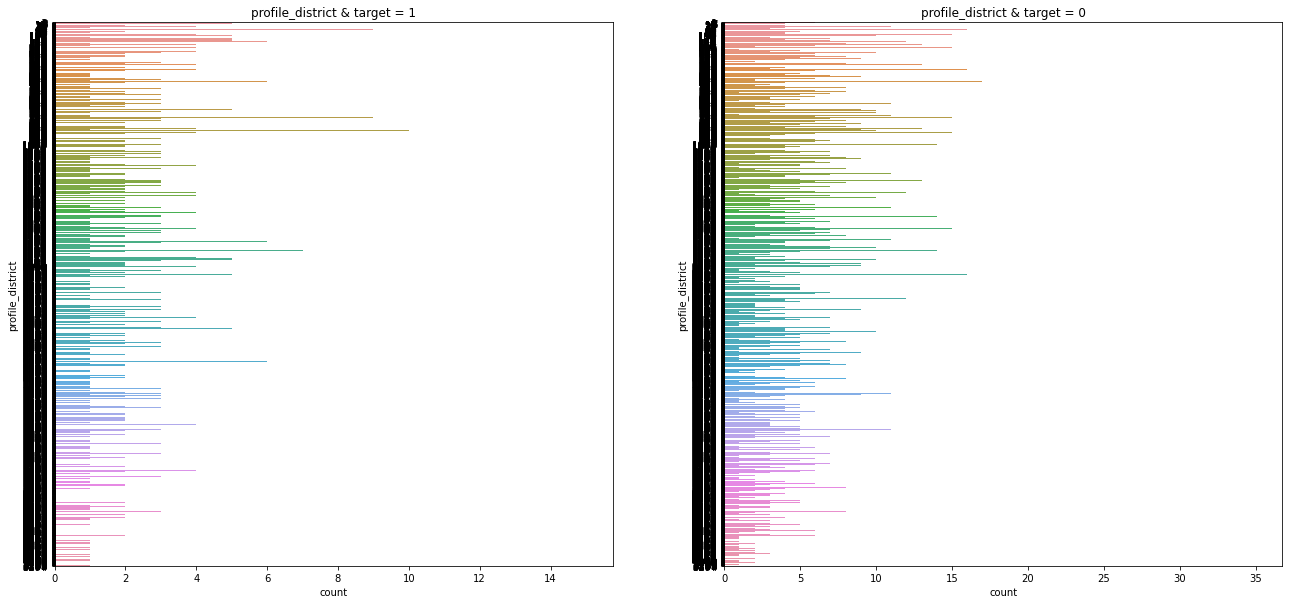

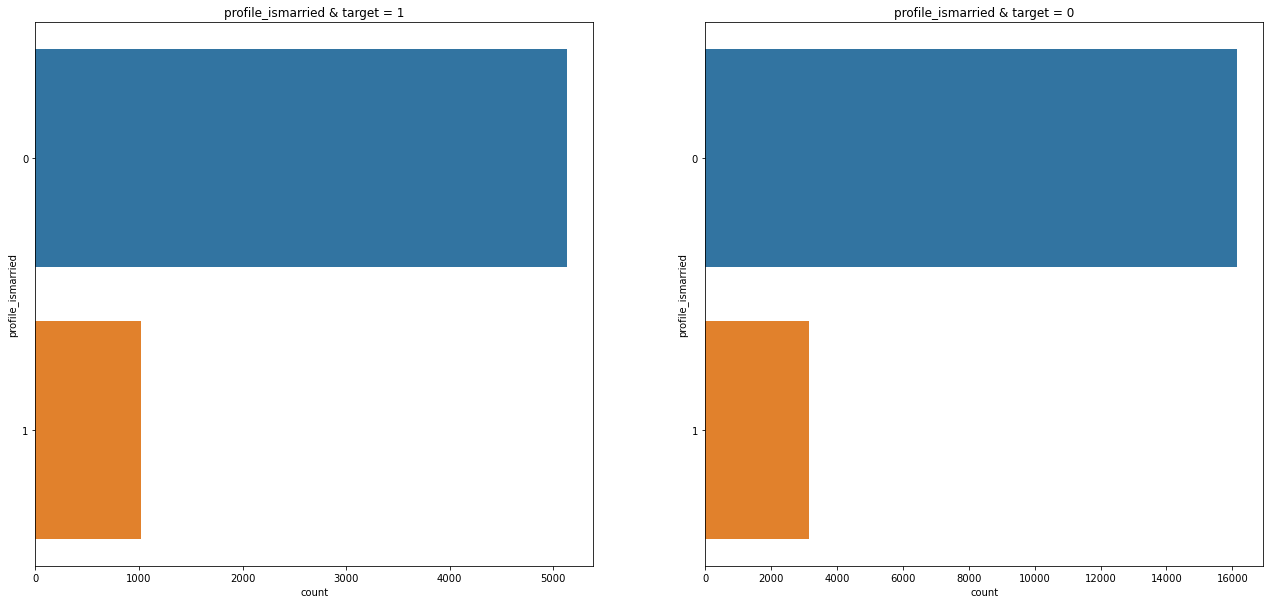

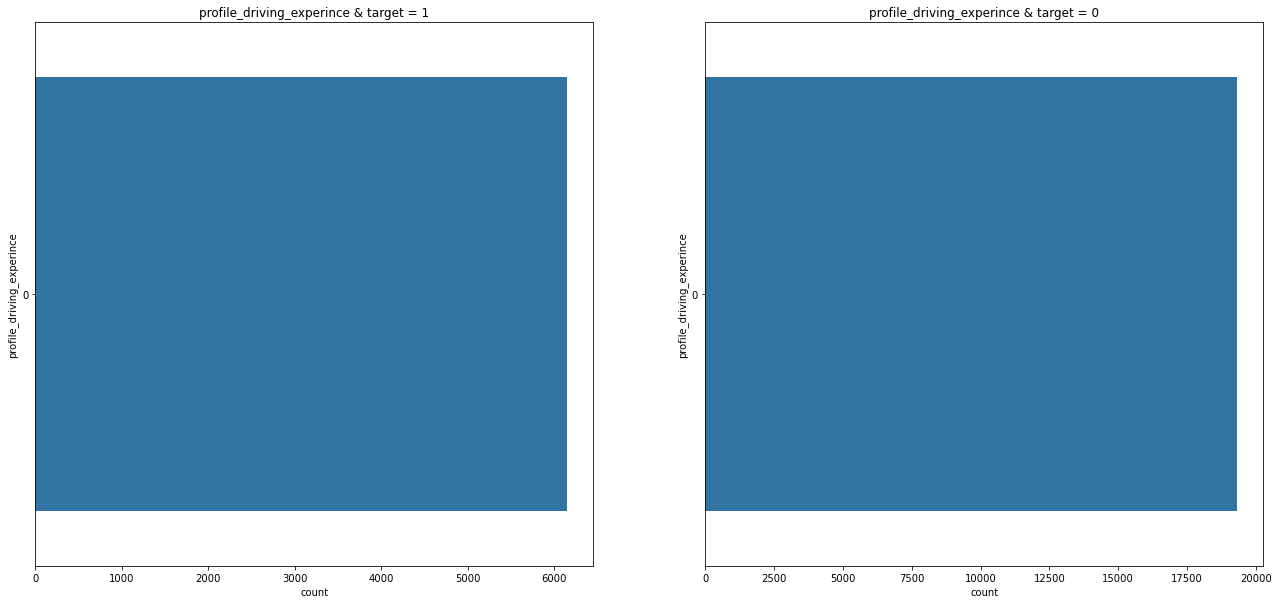

Wall time: 2min 19s


In [31]:
%%time

cols_target = profile_col
for col in cols_target:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    unique_values = [x for x in list(set(df_train[col].values).intersection(set(df_test[col].values))) if str(x) != 'nan']
    sns.countplot(y=col, ax=ax[0], data=df_train.loc[df_train['target'] == 1], order=unique_values)
    ax[0].set_title(col + ' & target = 1')
    sns.countplot(y=col, ax=ax[1], data=df_train.loc[df_train['target'] == 0], order=unique_values)
    ax[1].set_title(col + ' & target = 0')
    plt.show()

### 1.2. car_* - car features

- 'car_color' - цвет машины, 10 уникальных значений
- 'car_type' - тип машины, 22 уникальных значений

In [32]:
car_col = [col for col in df_train.columns if col.startswith('car_')]

In [33]:
df_train[car_col].head(4)

,car_color,car_type
0,3,8
1,3,4
2,0,9
3,-1,6


In [34]:
df_test[car_col].head(4)

,car_color,car_type
0,2,4
1,3,4
2,-1,3
3,2,3


Статистика

In [35]:
df_train[car_col].describe()

,car_color,car_type
count,25441.000000,25441.000000
mean,1.312252,8.398726
std,1.718214,5.435808
min,-1.000000,0.000000
25%,0.000000,4.000000
50%,2.000000,8.000000
75%,3.000000,13.000000
max,8.000000,21.000000


In [36]:
df_test[car_col].describe()

,car_color,car_type
count,25441.000000,25441.000000
mean,1.305648,8.327424
std,1.713791,5.406032
min,-1.000000,0.000000
25%,0.000000,4.000000
50%,2.000000,8.000000
75%,3.000000,12.000000
max,8.000000,21.000000


Распределение признаков

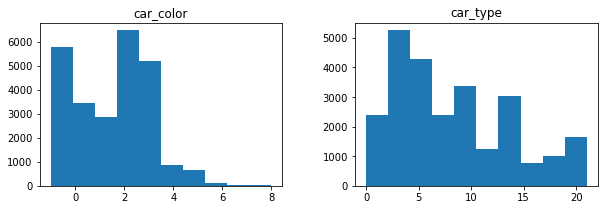

In [37]:
fig, axs = plt.subplots(1,2, figsize=(10, 3))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

axs = axs.ravel()

for i,j  in enumerate(df_train[car_col].columns):
        axs[i].hist(df_train[j])
        axs[i].set_title(str(j))

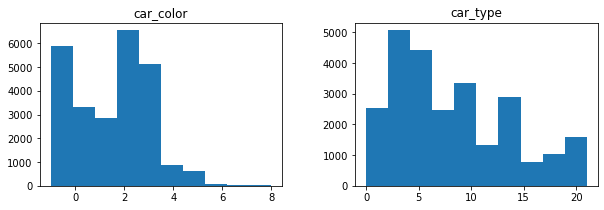

In [38]:
fig, axs = plt.subplots(1,2, figsize=(10, 3))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

axs = axs.ravel()

for i,j  in enumerate(df_test[car_col].columns):
        axs[i].hist(df_test[j])
        axs[i].set_title(str(j))

Корреляция

<AxesSubplot:>

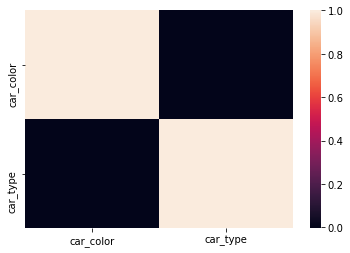

In [39]:
sns.heatmap(df_train[car_col].corr())

<AxesSubplot:>

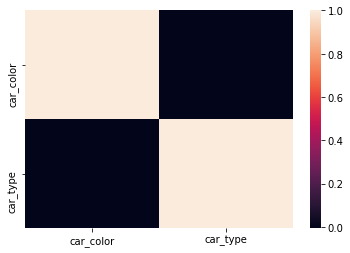

In [40]:
sns.heatmap(df_test[car_col].corr())

Зависимость таргета от признаков

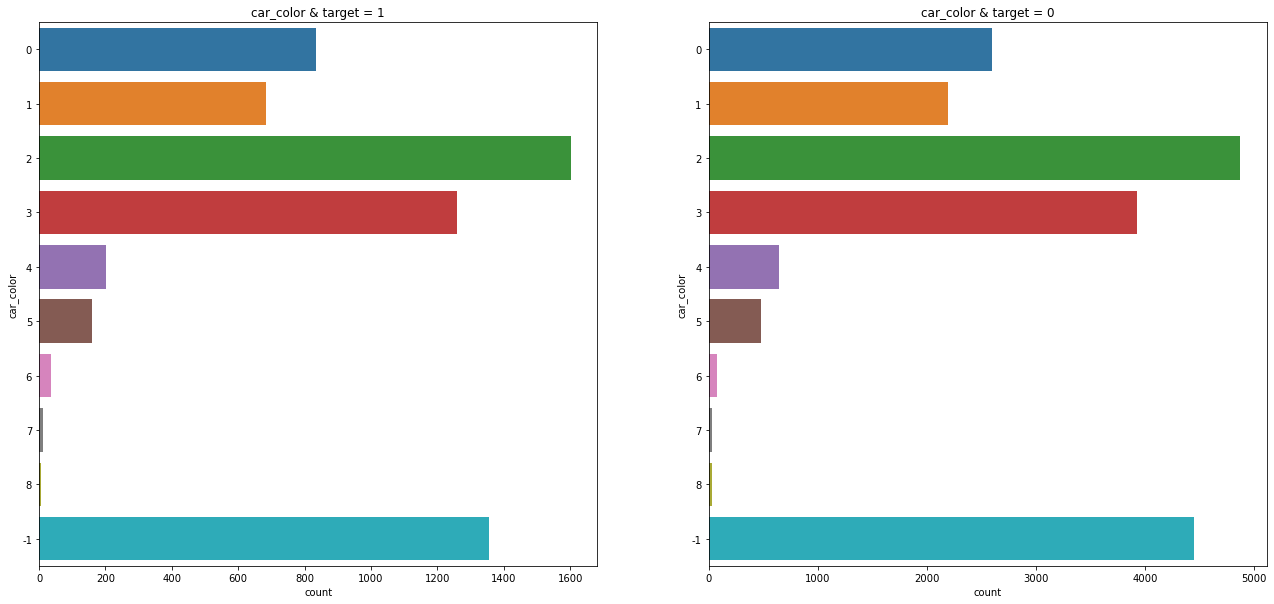

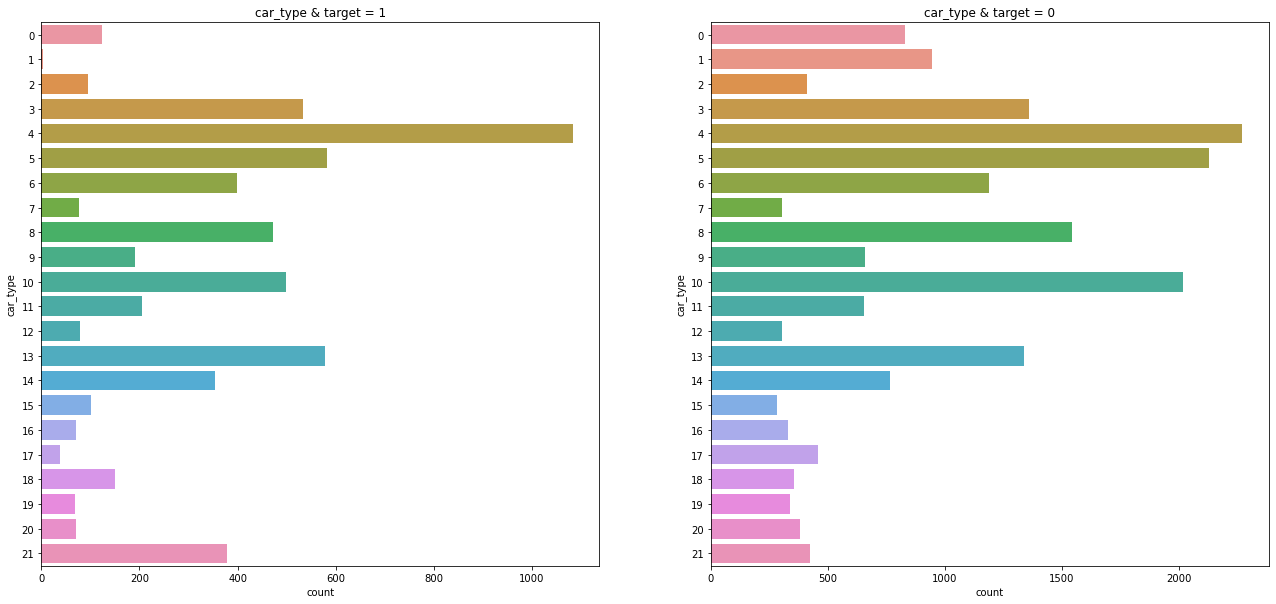

Wall time: 756 ms


In [41]:
%%time

cols_target = car_col
for col in cols_target:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    unique_values = [x for x in list(set(df_train[col].values).intersection(set(df_test[col].values))) if str(x) != 'nan']
    sns.countplot(y=col, ax=ax[0], data=df_train.loc[df_train['target'] == 1], order=unique_values)
    ax[0].set_title(col + ' & target = 1')
    sns.countplot(y=col, ax=ax[1], data=df_train.loc[df_train['target'] == 0], order=unique_values)
    ax[1].set_title(col + ' & target = 0')
    plt.show()

### 1.3. policy_* or tack_* - policy features

- 'policy_premium' - 4804 уникальных значений
- 'tack_discrepancy' - все значения уникальные, 25441 шт.
- 'tack_price'- все значения уникальные, 25441 шт. (стоимость страховки?)

In [42]:
tack_col = [col for col in df_train.columns if col.startswith('policy_') or col.startswith('tack_')]

In [43]:
df_train[tack_col].head(4)

,policy_premium,tack_discrepancy,tack_price
0,3121.0,1.760792,1251.363523
1,4579.0,-0.862687,2649.212376
2,7513.0,0.912160,1182.372635
3,5158.0,0.989353,7418.722849


In [44]:
df_test[tack_col].head(4)

,policy_premium,tack_discrepancy,tack_price
0,3488.0,-1.061691,8699.459528
1,9153.0,-0.572147,6415.276955
2,2235.0,1.235422,6078.137177
3,5334.0,-1.454151,4327.292598


Статистика

In [45]:
df_train[tack_col].describe()

,policy_premium,tack_discrepancy,tack_price
count,25441.000000,25441.000000,25441.000000
mean,4257.089187,-0.005870,7140.159918
std,1984.861707,0.996520,5630.967247
min,684.000000,-3.992961,0.063761
25%,2776.000000,-0.675703,2824.795023
50%,3942.000000,-0.010356,5830.286738
75%,5442.000000,0.670593,10097.316437
max,12695.000000,3.831790,40736.816876


In [46]:
df_test[tack_col].describe()

,policy_premium,tack_discrepancy,tack_price
count,25441.000000,25441.000000,25441.000000
mean,4253.280374,-0.002172,7139.961842
std,1969.192822,0.997092,5622.599142
min,684.000000,-4.659953,0.507302
25%,2770.000000,-0.667653,2818.679722
50%,3966.000000,0.006238,5859.447911
75%,5426.000000,0.665048,10130.267910
max,13005.000000,3.803844,38695.885531


Распределение признаков

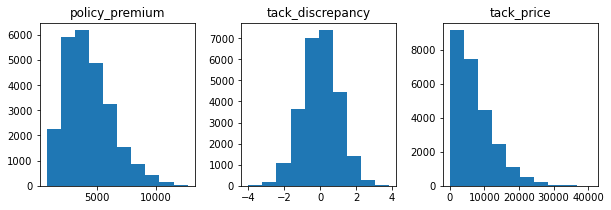

In [47]:
fig, axs = plt.subplots(1,3, figsize=(10, 3))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

axs = axs.ravel()

for i,j  in enumerate(df_train[tack_col].columns):
        axs[i].hist(df_train[j])
        axs[i].set_title(str(j))

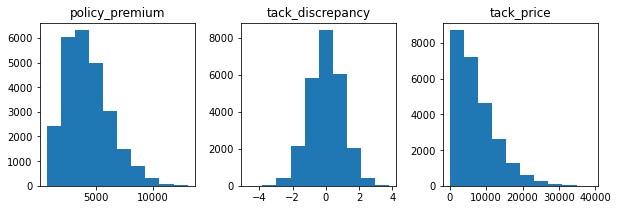

In [48]:
fig, axs = plt.subplots(1,3, figsize=(10, 3))
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

axs = axs.ravel()

for i,j  in enumerate(df_test[tack_col].columns):
        axs[i].hist(df_test[j])
        axs[i].set_title(str(j))

<AxesSubplot:>

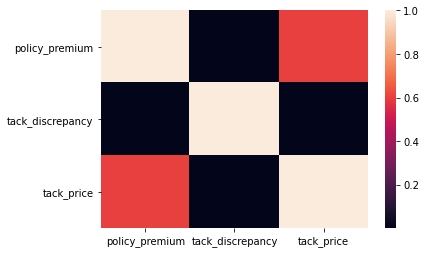

In [49]:
sns.heatmap(df_train[tack_col].corr())

Зависимость таргета от признаков

### 1.4. town_* - town features

'town_emb_0' - 'town_emb_49' - только 36 уникаьлных значений,float значения возле 0, также принимают отрицательные значения. Не сильно скоррелированы между собой

In [50]:
town_col = [col for col in df_train.columns if col.startswith('town_')]

In [51]:
df_train[town_col].head(4)

,town_emb_0,town_emb_1,town_emb_2,town_emb_3,town_emb_4,town_emb_5,town_emb_6,town_emb_7,town_emb_8,town_emb_9,...,town_emb_40,town_emb_41,town_emb_42,town_emb_43,town_emb_44,town_emb_45,town_emb_46,town_emb_47,town_emb_48,town_emb_49
0,0.177338,0.015891,-0.162692,-0.111103,0.052571,-0.103203,-0.142736,0.083409,0.269398,0.042577,...,0.047072,-0.340746,-0.037772,-0.007681,-0.016206,-0.015239,0.006937,0.020404,0.122847,0.196907
1,-0.292369,0.069586,-0.177793,0.172538,-0.165948,-0.076037,0.034272,0.117004,-0.088482,0.109726,...,-0.210861,-0.329802,0.064689,-0.088742,0.063294,0.083025,0.018835,0.340830,-0.124735,-0.083383
2,0.252408,-0.080992,-0.077402,-0.089823,0.018624,0.066401,-0.073055,-0.084635,-0.098785,0.121774,...,-0.081357,0.134258,-0.040898,-0.027169,-0.214965,0.083402,-0.196138,-0.169429,-0.228480,-0.190936
3,-0.029953,0.133104,-0.022158,-0.213020,0.035678,0.095119,-0.166987,0.001921,-0.002361,-0.035639,...,0.069376,0.037055,-0.159889,-0.218807,-0.038711,-0.040892,-0.173973,-0.123272,-0.227126,0.105457


Статистика

In [52]:
df_test[town_col].head(4)

,town_emb_0,town_emb_1,town_emb_2,town_emb_3,town_emb_4,town_emb_5,town_emb_6,town_emb_7,town_emb_8,town_emb_9,...,town_emb_40,town_emb_41,town_emb_42,town_emb_43,town_emb_44,town_emb_45,town_emb_46,town_emb_47,town_emb_48,town_emb_49
0,-0.057672,-0.096138,0.002487,-0.084760,0.076916,0.047658,-0.053832,0.012266,0.014953,-0.058755,...,0.096939,0.018502,0.095900,0.001259,-0.038660,-0.106153,0.078991,0.043605,0.097162,-0.042072
1,0.178840,-0.068806,0.250395,-0.026515,-0.137599,0.103607,-0.128786,0.101810,0.230408,0.051423,...,-0.096378,-0.139835,0.043236,-0.063148,-0.007503,0.012712,-0.025839,-0.065324,-0.047734,0.037695
2,0.041423,0.028773,0.096907,-0.067928,-0.144774,0.013824,0.038110,-0.154976,0.011106,0.109777,...,-0.023095,0.053463,-0.054910,-0.134653,-0.001585,0.130071,-0.094522,0.100126,-0.087543,-0.081398
3,0.007922,0.143811,0.024994,0.071618,-0.056302,0.000159,0.119422,-0.006891,-0.057455,-0.047415,...,0.091466,0.052520,0.054432,0.059284,0.155177,0.030978,0.071709,0.089853,-0.135898,0.069630


In [53]:
df_train[town_col].describe()

,town_emb_0,town_emb_1,town_emb_2,town_emb_3,town_emb_4,town_emb_5,town_emb_6,town_emb_7,town_emb_8,town_emb_9,...,town_emb_40,town_emb_41,town_emb_42,town_emb_43,town_emb_44,town_emb_45,town_emb_46,town_emb_47,town_emb_48,town_emb_49
count,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,...,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000
mean,0.006128,0.003792,-0.002124,0.005518,-0.004243,-0.004564,-0.001615,-0.003175,0.005091,0.010011,...,-0.020392,-0.007830,-0.014401,-0.002153,-0.004703,0.015670,-0.015396,-0.009539,-0.003216,0.003886
std,0.102057,0.115615,0.112482,0.098615,0.098578,0.090173,0.095033,0.103989,0.107081,0.096345,...,0.125846,0.131013,0.108586,0.132125,0.112246,0.106787,0.122017,0.137124,0.127487,0.111749
min,-0.292369,-0.263101,-0.320862,-0.213020,-0.165948,-0.162393,-0.192200,-0.222870,-0.239101,-0.236469,...,-0.462125,-0.353253,-0.306265,-0.257340,-0.272057,-0.214129,-0.302638,-0.315484,-0.228480,-0.315254
25%,-0.057672,-0.096138,-0.077402,-0.084760,-0.056302,-0.082348,-0.053832,-0.084635,-0.057455,-0.058755,...,-0.101562,-0.100933,-0.060977,-0.088742,-0.054918,-0.099897,-0.094522,-0.104579,-0.124735,-0.060437
50%,0.007922,-0.013335,0.002487,0.033644,-0.029010,0.000159,0.001811,0.012266,0.011106,-0.047415,...,-0.008968,0.018502,0.022610,0.001259,-0.038660,0.030978,0.006937,0.043605,-0.011341,-0.010494
75%,0.041423,0.097221,0.034749,0.071618,0.076916,0.047658,0.075978,0.047082,0.035345,0.095746,...,0.091466,0.052520,0.064689,0.059284,0.087977,0.108285,0.078991,0.089853,0.097162,0.069630
max,0.337079,0.278441,0.308478,0.207881,0.292844,0.228675,0.181690,0.284094,0.308581,0.256764,...,0.344176,0.282371,0.156993,0.407177,0.219243,0.253604,0.183501,0.340830,0.361360,0.353501


In [54]:
df_test[town_col].describe()

,town_emb_0,town_emb_1,town_emb_2,town_emb_3,town_emb_4,town_emb_5,town_emb_6,town_emb_7,town_emb_8,town_emb_9,...,town_emb_40,town_emb_41,town_emb_42,town_emb_43,town_emb_44,town_emb_45,town_emb_46,town_emb_47,town_emb_48,town_emb_49
count,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,...,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000,25441.000000
mean,0.006540,0.001475,-0.001962,0.005555,-0.003522,-0.005103,-0.002987,-0.003009,0.005701,0.010472,...,-0.019771,-0.008066,-0.013330,-0.002053,-0.006114,0.013964,-0.015001,-0.010640,-0.004352,0.001789
std,0.103192,0.114864,0.112992,0.098839,0.098756,0.089834,0.094487,0.104833,0.107530,0.096319,...,0.126441,0.131295,0.108349,0.131491,0.111883,0.106952,0.121847,0.137945,0.126668,0.110905
min,-0.292369,-0.263101,-0.320862,-0.213020,-0.165948,-0.162393,-0.192200,-0.222870,-0.239101,-0.236469,...,-0.462125,-0.353253,-0.306265,-0.257340,-0.272057,-0.214129,-0.302638,-0.315484,-0.228480,-0.315254
25%,-0.057672,-0.096138,-0.077402,-0.084760,-0.056302,-0.082348,-0.053832,-0.084635,-0.057455,-0.058755,...,-0.101562,-0.100933,-0.060977,-0.088742,-0.054918,-0.099897,-0.094522,-0.104579,-0.124735,-0.060437
50%,0.007922,-0.030578,0.002487,0.033644,-0.029010,0.000159,0.001811,0.012266,0.011106,-0.047415,...,-0.008770,0.018502,0.022610,0.001259,-0.038660,0.030978,0.006937,0.043605,-0.011341,-0.010494
75%,0.041423,0.086644,0.034749,0.089775,0.076916,0.047658,0.075978,0.047082,0.035345,0.095746,...,0.091466,0.052520,0.075786,0.059284,0.071788,0.108285,0.078991,0.089853,0.097162,0.069630
max,0.337079,0.278441,0.308478,0.207881,0.292844,0.228675,0.181690,0.284094,0.308581,0.256764,...,0.344176,0.282371,0.156993,0.407177,0.219243,0.253604,0.183501,0.340830,0.361360,0.353501


Распределение

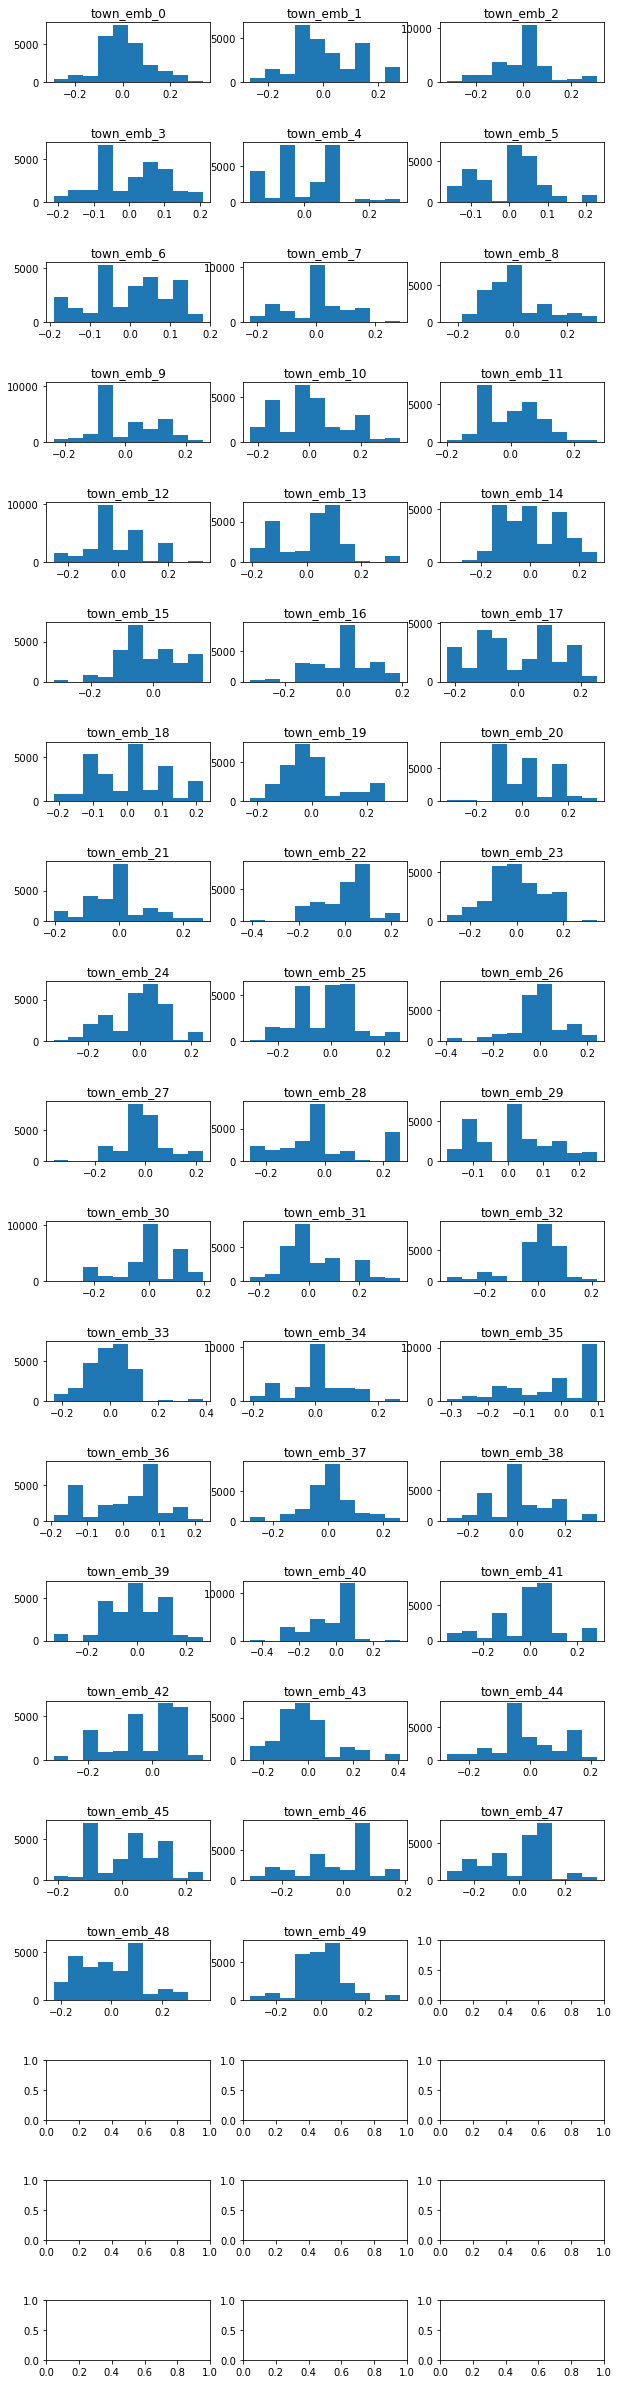

In [55]:
fig, axs = plt.subplots(20,3, figsize=(10, 43))
fig.subplots_adjust(hspace = 1, wspace=0.2)

axs = axs.ravel()

for i,j  in enumerate(df_train[town_col].columns):
        axs[i].hist(df_train[j])
        axs[i].set_title(str(j))

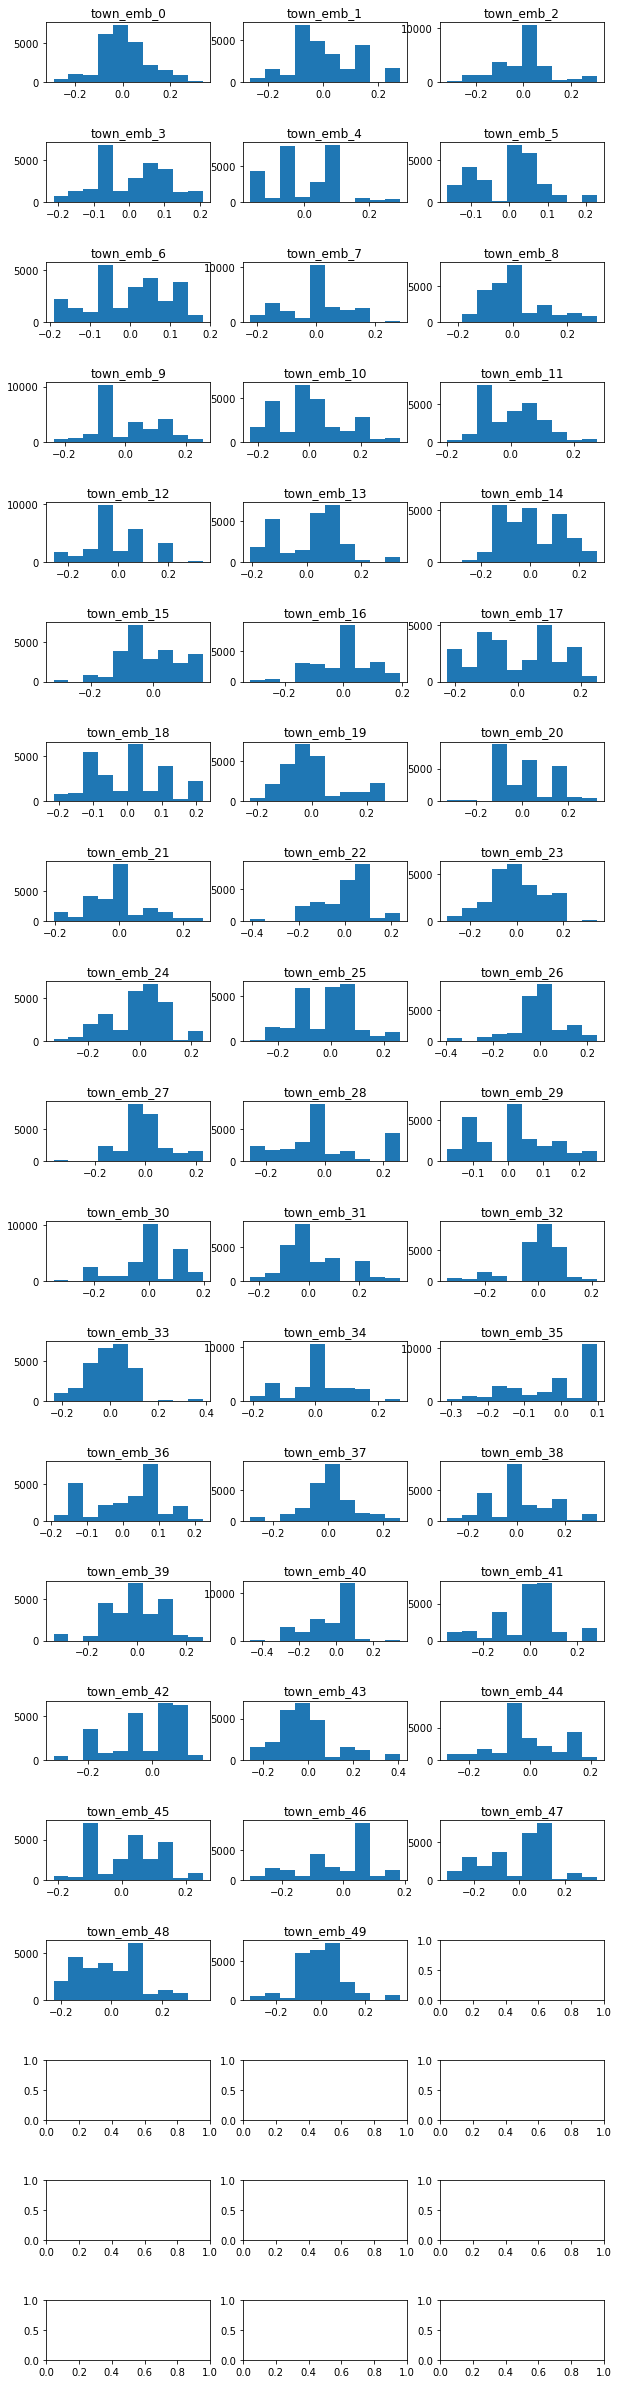

In [56]:
fig, axs = plt.subplots(20,3, figsize=(10, 43))
fig.subplots_adjust(hspace = 1, wspace=0.2)

axs = axs.ravel()

for i,j  in enumerate(df_test[town_col].columns):
        axs[i].hist(df_test[j])
        axs[i].set_title(str(j))

<AxesSubplot:>

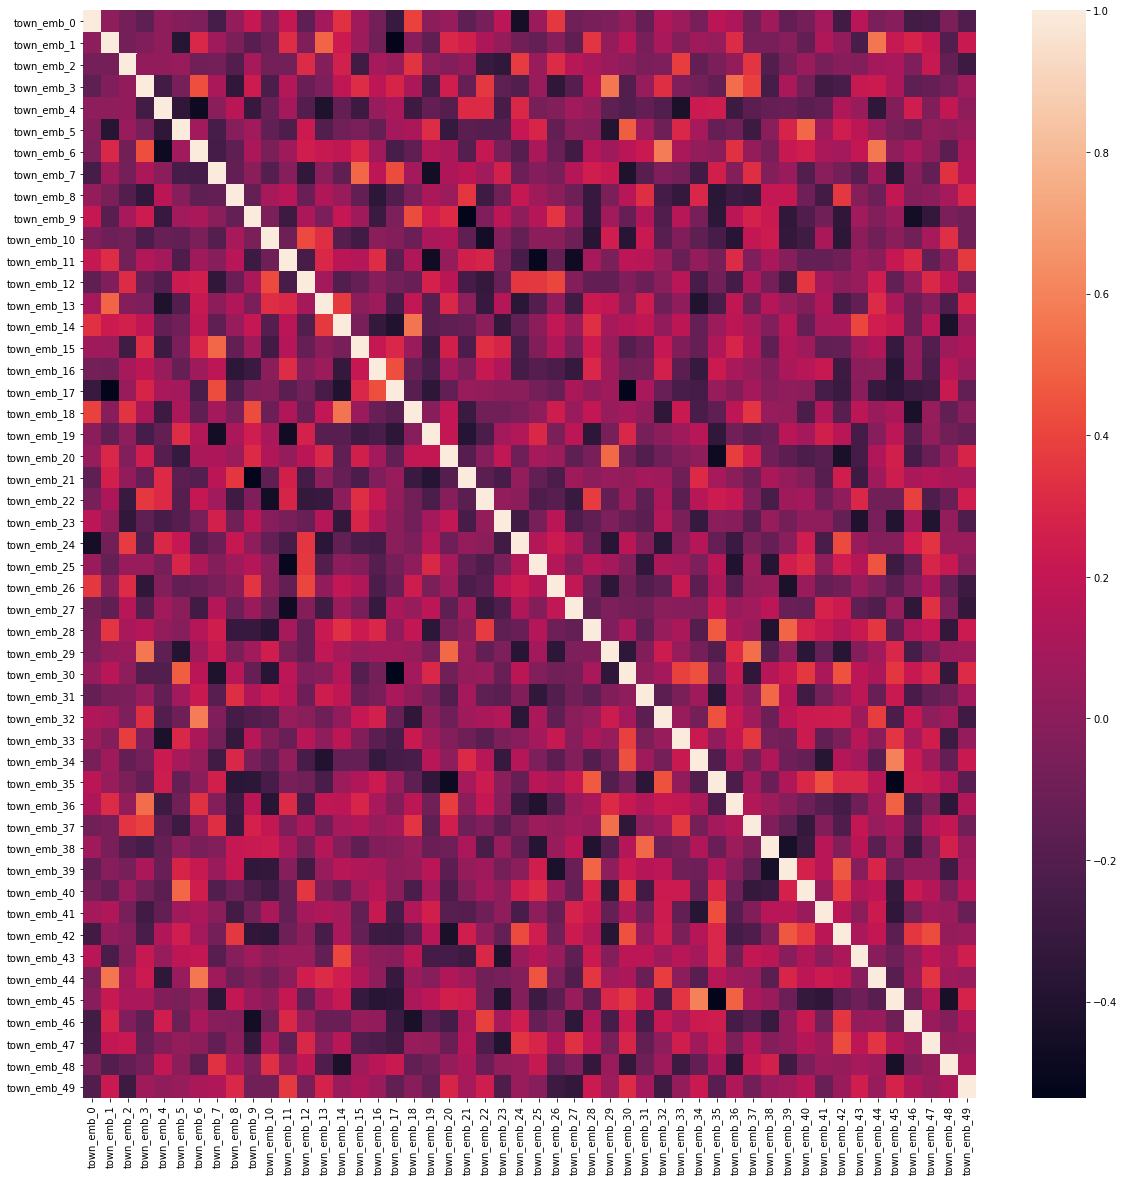

In [57]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_train[town_col].corr(), ax=ax)

<AxesSubplot:>

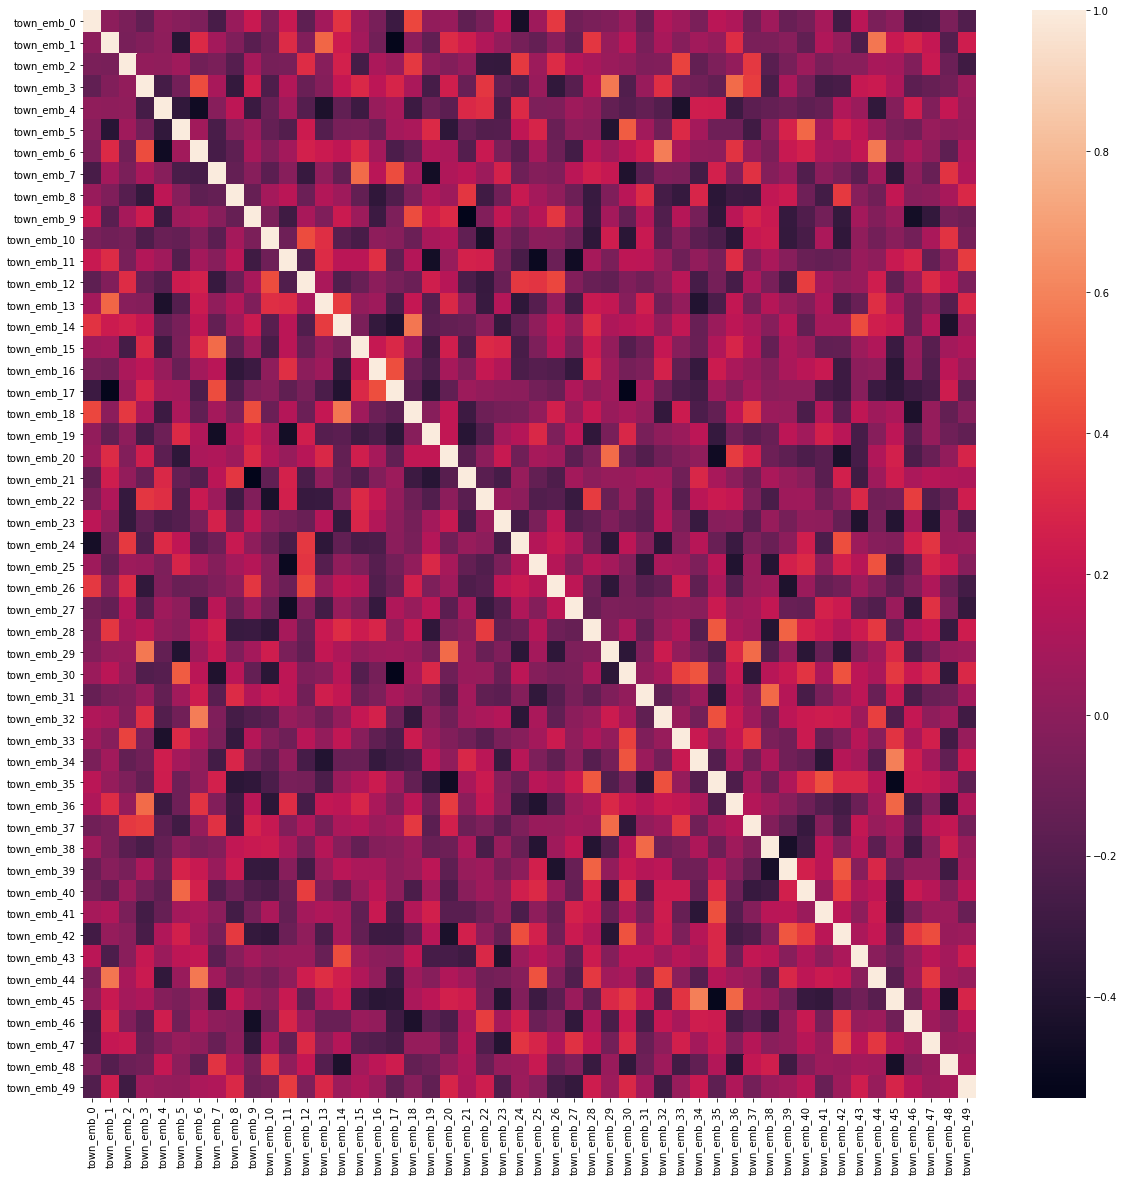

In [58]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(df_test[town_col].corr(), ax=ax)

## 2. Модель 

### 2.1. LightGBM

In [59]:
X, y = df_train.loc[:, (df_train.columns != 'target')&(df_train.columns != 'id') & (df_train.columns != 'profile_driving_experince')], df_train.loc[:, df_train.columns == 'target']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [61]:
lgbtrain = lgb.Dataset(X_train, label=y_train)
lgbtest = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'early_stopping_rounds': 20,
}

lgb_model = lgb.train(params, lgbtrain, valid_sets=[lgbtrain, lgbtest], verbose_eval=10)
pred  = lgb_model.predict(X_test)

[LightGBM] [Info] Number of positive: 4137, number of negative: 12908
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3003
[LightGBM] [Info] Number of data points in the train set: 17045, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.242710 -> initscore=-1.137876
[LightGBM] [Info] Start training from score -1.137876
Training until validation scores don't improve for 20 rounds
[10]	training's auc: 0.685939	valid_1's auc: 0.609312
[20]	training's auc: 0.720018	valid_1's auc: 0.606961
Early stopping, best iteration is:
[6]	training's auc: 0.673021	valid_1's auc: 0.610635


In [62]:
imp = pd.DataFrame(X_train.columns, columns = ['feature'])
imp['importance'] = lgb_model.feature_importance()

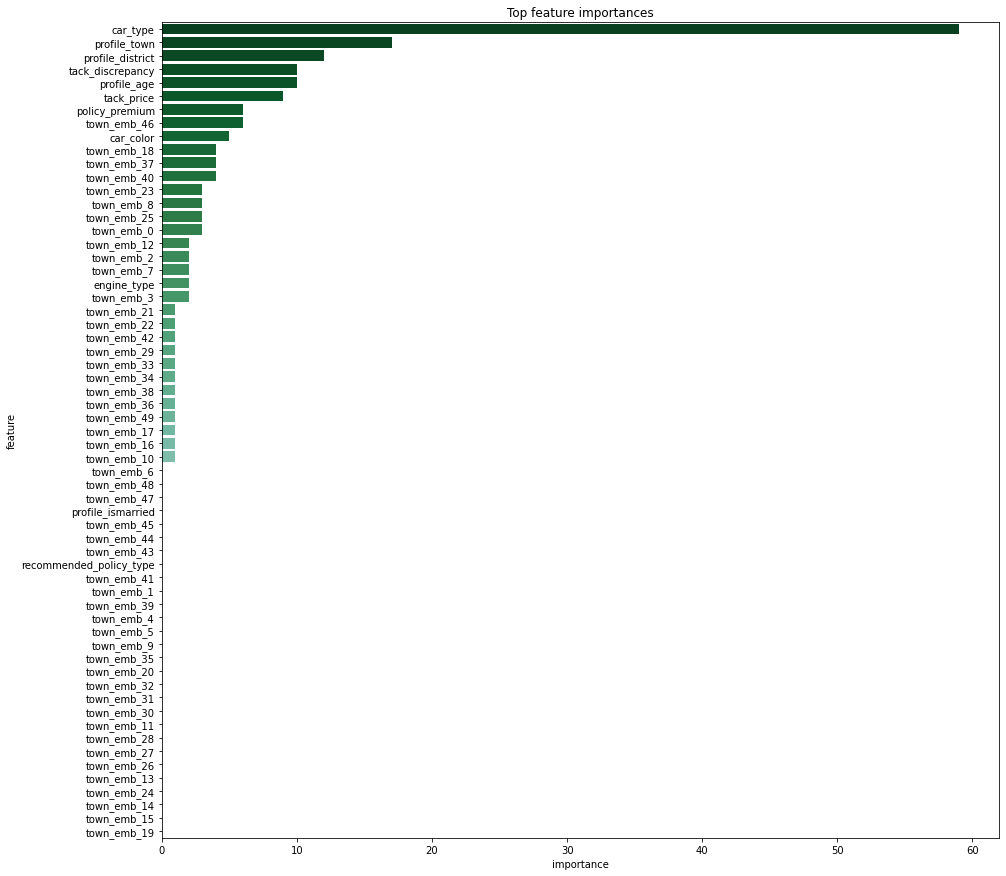

In [63]:
plt.figure(figsize=(15, 15))
sns.barplot(data=imp.sort_values(by='importance', ascending=False),x='importance', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

### 2.2. CATBoost

Закодируем признаки town_col, чтобы учитывать их как категориальные

In [65]:
for col in tqdm(town_col):
       
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])

  0%|          | 0/50 [00:00<?, ?it/s]

In [66]:
X, y = df_train.loc[:, (df_train.columns != 'target')&(df_train.columns != 'id') & (df_train.columns != 'profile_driving_experince')], df_train.loc[:, df_train.columns == 'target']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Выделим категориальные признаки

In [68]:
cat_features = ['profile_town', 'profile_district', 'profile_ismarried', 'engine_type',
       'recommended_policy_type', 'car_color', 'car_type'] +town_col

In [69]:
model = CatBoostClassifier(loss_function='Logloss', verbose = 100)

In [70]:
model.fit(X_train, y_train, cat_features)
# Get predicted classes

preds_proba = model.predict_proba(X_test)
# Get predicted RawFormulaVal
metric = roc_auc_score(y_test, preds_proba[:,1])

Learning rate set to 0.03458
0:	learn: 0.6824751	total: 180ms	remaining: 3m
100:	learn: 0.4728872	total: 10.3s	remaining: 1m 31s
200:	learn: 0.4634940	total: 20.6s	remaining: 1m 21s
300:	learn: 0.4566588	total: 31.2s	remaining: 1m 12s
400:	learn: 0.4469884	total: 42.5s	remaining: 1m 3s
500:	learn: 0.4386619	total: 53.9s	remaining: 53.7s
600:	learn: 0.4315384	total: 1m 6s	remaining: 43.9s
700:	learn: 0.4243383	total: 1m 18s	remaining: 33.5s
800:	learn: 0.4176186	total: 1m 31s	remaining: 22.8s
900:	learn: 0.4111154	total: 1m 44s	remaining: 11.5s
999:	learn: 0.4045457	total: 1m 58s	remaining: 0us


In [71]:
metric = roc_auc_score(y_test, preds_proba[:,1])

In [72]:
metric

0.7682946026846441

In [73]:
print(model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'Logloss', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 1000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Un

In [74]:
imp_catboost = pd.DataFrame(X_train.columns, columns = ['feature'])
imp_catboost['importance'] = model.feature_importances_

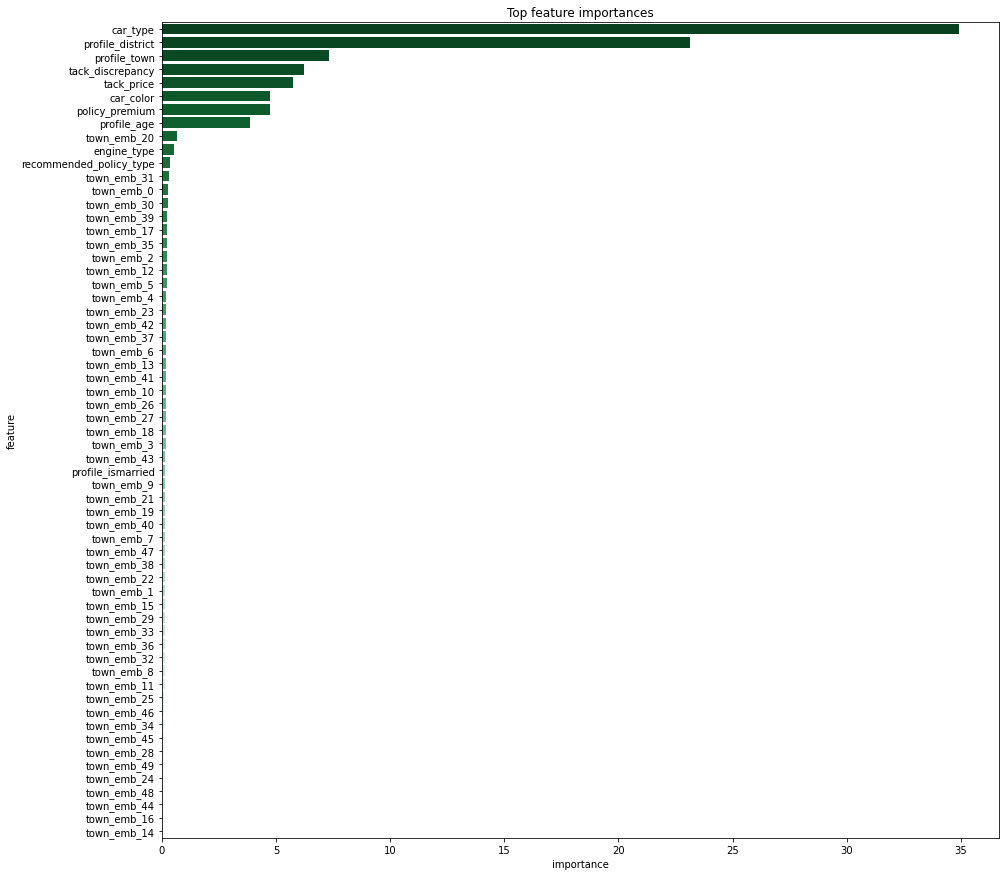

In [75]:
plt.figure(figsize=(15, 15))
sns.barplot(data=imp_catboost.sort_values(by='importance', ascending=False),x='importance', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

Видно, что CatBoost с выделением категориальных признаков дает сильный прирост в качестве на тесте (+0.15 ROC-AUC)

Submit:

In [76]:
df_test.drop(columns = ['id', 'profile_driving_experince'], axis = 1, inplace = True)

In [77]:
test_preds = model.predict_proba(df_test)

In [78]:
test_preds

array([[0.49730149, 0.50269851],
       [0.92808793, 0.07191207],
       [0.56695528, 0.43304472],
       ...,
       [0.92085345, 0.07914655],
       [0.9426807 , 0.0573193 ],
       [0.91104491, 0.08895509]])

In [79]:
test_id = pd.read_csv('test_hse1.csv')
sub = pd.DataFrame({'id': test_id['id'], 'target': test_preds[:,1]})

In [80]:
sub

,id,target
0,36145,0.502699
1,24679,0.071912
2,8093,0.433045
3,42129,0.319484
4,1323,0.420939
...,...,...
25436,21371,0.415025
25437,2007,0.145960
25438,2727,0.079147
25439,35491,0.057319


In [81]:
sub.to_csv('submission_3.csv', index = False)

In [82]:
pd.read_csv('submission_3.csv')

In [83]:
sample = pd.read_csv('sample_submission.csv')

In [84]:
sample['target'].hist()

### 2.3. CATBoost + k fold валидация

Настроим валидацию, чтобы лучше оценивать обобщающую способность алгоритма.

In [85]:
from sklearn.model_selection import KFold

In [86]:
kf = KFold(n_splits=3)
roc_auc = []
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train, cat_features)
    preds_proba = model.predict_proba(X_test)
    
    metric = roc_auc_score(y_test, preds_proba[:,1])
    roc_auc.append(metric)  
    
print('ROC_AUC for 3-k-fold cross-validation: ', np.mean(roc_auc))

Learning rate set to 0.034506
0:	learn: 0.6831275	total: 26.5ms	remaining: 26.5s
100:	learn: 0.4739074	total: 12.6s	remaining: 1m 52s
200:	learn: 0.4633888	total: 26.2s	remaining: 1m 43s
300:	learn: 0.4556103	total: 39.7s	remaining: 1m 32s
400:	learn: 0.4463694	total: 54s	remaining: 1m 20s
500:	learn: 0.4379271	total: 1m 7s	remaining: 1m 7s
600:	learn: 0.4304552	total: 1m 21s	remaining: 54.3s
700:	learn: 0.4234356	total: 1m 35s	remaining: 40.8s
800:	learn: 0.4162718	total: 1m 49s	remaining: 27.3s
900:	learn: 0.4097301	total: 2m 3s	remaining: 13.6s
999:	learn: 0.4029360	total: 2m 17s	remaining: 0us
Learning rate set to 0.034507
0:	learn: 0.6832004	total: 102ms	remaining: 1m 42s
100:	learn: 0.4781143	total: 12.1s	remaining: 1m 47s
200:	learn: 0.4672001	total: 25.3s	remaining: 1m 40s
300:	learn: 0.4587691	total: 38.8s	remaining: 1m 30s
400:	learn: 0.4485890	total: 52.5s	remaining: 1m 18s
500:	learn: 0.4394325	total: 1m 6s	remaining: 1m 6s
600:	learn: 0.4310064	total: 1m 22s	remaining: 54.

In [87]:
print('ROC_AUC for 3-k-fold cross-validation: ', np.mean(roc_auc))

ROC_AUC for 3-k-fold cross-validation:  0.7668720412159824


## 3. Дополнительные признаки

Попробуем улучшить качество и сгенерируем дополнительные признаки.

### 3.1. Категориальные

Попробуем сгенерировать новые признаки из самых значимых, при этом будем добавлять признаки в копию датасета, чтобы сначала тестировать влияние новых признаков на валидации и только после этого добавлять к данным

In [90]:
df_train_ = df_train.copy()

In [91]:
df_train_['car_type_profile_town'] = df_train_['car_type'].astype(str) + '_' + df_train_['profile_town'].astype(str)
df_train_['car_type_profile_district'] = df_train_['car_type'].astype(str) + '_' + df_train_['profile_district'].astype(str)
df_train_['profile_town_profile_district'] = df_train_['profile_town'].astype(str) + '_' + df_train_['profile_district'].astype(str)
df_train_['profile_town_profile_district_car_type'] = df_train_['profile_town'].astype(str) + '_' + df_train_['profile_district'].astype(str)+ '_' + df_train_['car_type'].astype(str)
df_train_['car_type_car_color'] = df_train_['car_type'].astype(str) + '_' + df_train_['car_color'].astype(str)

Протестируем улучшают ли признаки качество на валидации

In [92]:
X_, y_ = df_train_.loc[:, (df_train_.columns != 'target')&(df_train_.columns != 'id') & (df_train_.columns != 'profile_driving_experince')], df_train_.loc[:, df_train_.columns == 'target']

In [93]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.33, random_state=42)

In [94]:
cat_features_ = ['profile_town', 'profile_district', 'profile_ismarried', 'engine_type',
       'recommended_policy_type', 'car_color', 'car_type', 'car_type_profile_town',
                'car_type_profile_district', 'profile_town_profile_district', 
                "profile_town_profile_district_car_type", 'car_type_car_color'] +town_col

In [95]:
kf = KFold(n_splits=3)
roc_auc = []
for train_index, test_index in kf.split(X_):

    X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index]
    y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]

    model.fit(X_train_, y_train_, cat_features_)
    preds_proba = model.predict_proba(X_test_)
    
    metric = roc_auc_score(y_test_, preds_proba[:,1])
    roc_auc.append(metric)
print('ROC_AUC for 3-k-fold cross-validation: ', np.mean(roc_auc))

Learning rate set to 0.034506
0:	learn: 0.6822950	total: 117ms	remaining: 1m 57s
100:	learn: 0.4724951	total: 14.4s	remaining: 2m 8s
200:	learn: 0.4612016	total: 30s	remaining: 1m 59s
300:	learn: 0.4529473	total: 45.6s	remaining: 1m 46s
400:	learn: 0.4437012	total: 1m 2s	remaining: 1m 33s
500:	learn: 0.4354177	total: 1m 17s	remaining: 1m 17s
600:	learn: 0.4271497	total: 1m 33s	remaining: 1m 2s
700:	learn: 0.4196898	total: 1m 48s	remaining: 46.4s
800:	learn: 0.4132865	total: 2m 4s	remaining: 31s
900:	learn: 0.4062738	total: 2m 20s	remaining: 15.4s
999:	learn: 0.4002145	total: 2m 36s	remaining: 0us
Learning rate set to 0.034507
0:	learn: 0.6815851	total: 59ms	remaining: 59s
100:	learn: 0.4761106	total: 14s	remaining: 2m 4s
200:	learn: 0.4659280	total: 28.8s	remaining: 1m 54s
300:	learn: 0.4575997	total: 44.2s	remaining: 1m 42s
400:	learn: 0.4476967	total: 1m	remaining: 1m 29s
500:	learn: 0.4387491	total: 1m 16s	remaining: 1m 15s
600:	learn: 0.4313465	total: 1m 31s	remaining: 1m
700:	lear

In [96]:
print('ROC_AUC for 3-k-fold cross-validation: ', np.mean(roc_auc))

ROC_AUC for 3-k-fold cross-validation:  0.7675960374232643


Метрика на валидации улучшилась, значит можем добавить эти признаки в трейн и тест

In [97]:
df_train['car_type_profile_town'] = df_train['car_type'].astype(str) + '_' + df_train['profile_town'].astype(str)
df_train['car_type_profile_district'] = df_train['car_type'].astype(str) + '_' + df_train['profile_district'].astype(str)
df_train['profile_town_profile_district'] = df_train['profile_town'].astype(str) + '_' + df_train['profile_district'].astype(str)
df_train['profile_town_profile_district_car_type'] = df_train['profile_town'].astype(str) + '_' + df_train['profile_district'].astype(str)+ '_' + df_train['car_type'].astype(str)
df_train['car_type_car_color'] = df_train['car_type'].astype(str) + '_' + df_train['car_color'].astype(str)

In [98]:
df_test['car_type_profile_town'] = df_test['car_type'].astype(str) + '_' + df_test['profile_town'].astype(str)
df_test['car_type_profile_district'] = df_test['car_type'].astype(str) + '_' + df_test['profile_district'].astype(str)
df_test['profile_town_profile_district'] = df_test['profile_town'].astype(str) + '_' + df_test['profile_district'].astype(str)
df_test['profile_town_profile_district_car_type'] = df_test['profile_town'].astype(str) + '_' + df_test['profile_district'].astype(str)+ '_' + df_test['car_type'].astype(str)
df_test['car_type_car_color'] = df_test['car_type'].astype(str) + '_' + df_test['car_color'].astype(str)

## Дополнительные признаки_агрегации

Попробуем теперь сделать агрегации числовых признаков по самым значимым категориальным и новым сгенерированным категориальным. В качестве числовых признаков выберем 'tack_discrepancy', 'tack_price', т.к. признаки содержат все уникальные значения.

In [100]:
new_cols = []
for col in ['car_type', 'profile_district', 'profile_town', 'car_color', 'profile_age', 'car_type_profile_town', 
           'car_type_profile_district', 'profile_town_profile_district', 'profile_town_profile_district_car_type', 
           'car_type_car_color']:
    for agg_type in ['mean', 'median', 'min', 'max', 'count', 'sum']:
        agg_col_name = 'tack_discrepancy_{}_{}'.format(col, agg_type)
        field_agg = df_train_.groupby(col)['tack_discrepancy'].agg([agg_type]).rename({agg_type: agg_col_name}, axis=1)
        df_train_ = df_train_.merge(field_agg, how='left', on=col)
#         df_test_ = df_test.merge(field_agg, how='left', on=col)
        new_cols.append(agg_col_name)

In [101]:
new_cols = []
for col in ['car_type', 'profile_district', 'profile_town', 'car_color', 'profile_age', 'car_type_profile_town', 
           'car_type_profile_district', 'profile_town_profile_district', 'profile_town_profile_district_car_type', 
           'car_type_car_color']:
    for agg_type in ['mean', 'median', 'min', 'max', 'count', 'sum']:
        agg_col_name = 'tack_price_{}_{}'.format(col, agg_type)
        field_agg = df_train_.groupby(col)['tack_discrepancy'].agg([agg_type]).rename({agg_type: agg_col_name}, axis=1)
        df_train_ = df_train_.merge(field_agg, how='left', on=col)
#         df_test_ = df_test.merge(field_agg, how='left', on=col)
        new_cols.append(agg_col_name)

In [102]:
X_, y_ = df_train_.loc[:, (df_train_.columns != 'target')&(df_train_.columns != 'id') & (df_train_.columns != 'profile_driving_experince')], df_train_.loc[:, df_train_.columns == 'target']

In [103]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y_, test_size=0.33, random_state=42)

In [104]:
kf = KFold(n_splits=3)
roc_auc = []
feature_importances = pd.DataFrame(X_train_.columns, columns = ['feature'])
i = 0

for train_index, test_index in kf.split(X_):

    X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index]
    y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]

    model.fit(X_train_, y_train_, cat_features_)
    preds_proba = model.predict_proba(X_test_)
    
    feature_importances['fold_{}'.format(i)] = model.feature_importances_
    
    metric = roc_auc_score(y_test_, preds_proba[:,1])
    roc_auc.append(metric)
    i+=1
print('ROC_AUC for 3-k-fold cross-validation: ', np.mean(roc_auc))

Learning rate set to 0.034506
0:	learn: 0.6779065	total: 138ms	remaining: 2m 17s
100:	learn: 0.4577141	total: 15.4s	remaining: 2m 17s
200:	learn: 0.4444211	total: 31.8s	remaining: 2m 6s
300:	learn: 0.4326678	total: 47.8s	remaining: 1m 51s
400:	learn: 0.4199699	total: 1m 3s	remaining: 1m 35s
500:	learn: 0.4075435	total: 1m 19s	remaining: 1m 19s
600:	learn: 0.3963697	total: 1m 35s	remaining: 1m 3s
700:	learn: 0.3850507	total: 1m 51s	remaining: 47.5s
800:	learn: 0.3743800	total: 2m 6s	remaining: 31.5s
900:	learn: 0.3640732	total: 2m 22s	remaining: 15.7s
999:	learn: 0.3552795	total: 2m 38s	remaining: 0us
Learning rate set to 0.034507
0:	learn: 0.6775847	total: 158ms	remaining: 2m 37s
100:	learn: 0.4604217	total: 16.3s	remaining: 2m 24s
200:	learn: 0.4480552	total: 32s	remaining: 2m 7s
300:	learn: 0.4363789	total: 48s	remaining: 1m 51s
400:	learn: 0.4225354	total: 1m 3s	remaining: 1m 35s
500:	learn: 0.4093406	total: 1m 19s	remaining: 1m 19s
600:	learn: 0.3972101	total: 1m 35s	remaining: 1m 

In [105]:
print('ROC_AUC for 3-k-fold cross-validation: ', np.mean(roc_auc))

ROC_AUC for 3-k-fold cross-validation:  0.7798143437436166


In [106]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

,feature,fold_0,fold_1,fold_2,average
0,profile_age,0.992393,1.284434,0.991857,1.089561
1,profile_town,1.675360,0.733507,1.191563,1.200143
2,profile_district,1.517969,2.531278,1.335402,1.794883
3,profile_ismarried,0.083127,0.050144,0.030330,0.054534
4,engine_type,0.064174,0.435348,0.112032,0.203851


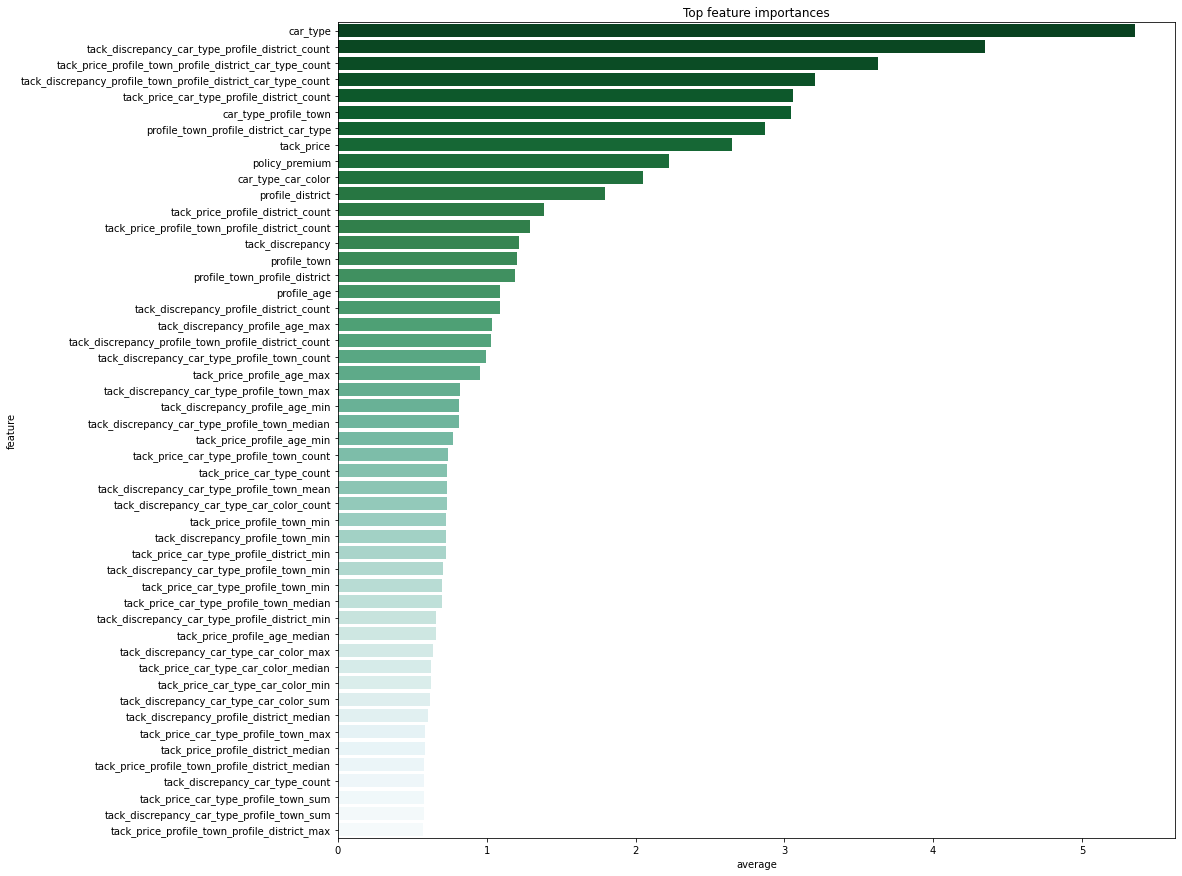

In [107]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

Метрика на валидации улучшилась, признаки попали в топ 50 для бустинга, значит можем добавить эти признаки в трейн и тест

In [108]:
new_cols = []
for col in ['car_type', 'profile_district', 'profile_town', 'car_color', 'profile_age', 'car_type_profile_town', 
           'car_type_profile_district', 'profile_town_profile_district', 'profile_town_profile_district_car_type', 
           'car_type_car_color']:
    for agg_type in ['mean', 'median', 'min', 'max', 'count', 'sum']:
        agg_col_name = 'tack_discrepancy_{}_{}'.format(col, agg_type)
        field_agg = df_train.groupby(col)['tack_discrepancy'].agg([agg_type]).rename({agg_type: agg_col_name}, axis=1)
        df_train = df_train.merge(field_agg, how='left', on=col)
        df_test = df_test.merge(field_agg, how='left', on=col)
        new_cols.append(agg_col_name)

In [109]:
new_cols = []
for col in ['car_type', 'profile_district', 'profile_town', 'car_color', 'profile_age', 'car_type_profile_town', 
           'car_type_profile_district', 'profile_town_profile_district', 'profile_town_profile_district_car_type', 
           'car_type_car_color']:
    for agg_type in ['mean', 'median', 'min', 'max', 'count', 'sum']:
        agg_col_name = 'tack_price_{}_{}'.format(col, agg_type)
        field_agg = df_train.groupby(col)['tack_price'].agg([agg_type]).rename({agg_type: agg_col_name}, axis=1)
        df_train = df_train.merge(field_agg, how='left', on=col)
        df_test = df_test.merge(field_agg, how='left', on=col)
        new_cols.append(agg_col_name)

## 4. Итоговая модель

Обучаем финальную модель с новыми признаками и делаем предикты для теста

In [111]:
# df_test.drop(columns = ['id', 'profile_driving_experince'], axis = 1, inplace = True)

In [112]:
kf = KFold(n_splits=3)
roc_auc = []
feature_importances = pd.DataFrame(X_train_.columns, columns = ['feature'])
i = 0

test_preds = []

for train_index, test_index in kf.split(X_):

    X_train_, X_test_ = X_.iloc[train_index], X_.iloc[test_index]
    y_train_, y_test_ = y_.iloc[train_index], y_.iloc[test_index]

    model.fit(X_train_, y_train_, cat_features_)
    preds_proba = model.predict_proba(X_test_)
    
    feature_importances['fold_{}'.format(i)] = model.feature_importances_
    
    metric = roc_auc_score(y_test_, preds_proba[:,1])
    roc_auc.append(metric)
    
    y_test_pred = model.predict_proba(df_test)
    test_preds.append(y_test_pred)
    
    i+=1
print('ROC_AUC for 3-k-fold cross-validation: ', np.mean(roc_auc))

Learning rate set to 0.034506
0:	learn: 0.6779065	total: 146ms	remaining: 2m 25s
100:	learn: 0.4577141	total: 13s	remaining: 1m 56s
200:	learn: 0.4444211	total: 27.2s	remaining: 1m 47s
300:	learn: 0.4326678	total: 41s	remaining: 1m 35s
400:	learn: 0.4199699	total: 54.8s	remaining: 1m 21s
500:	learn: 0.4075435	total: 1m 8s	remaining: 1m 8s
600:	learn: 0.3963697	total: 1m 22s	remaining: 55s
700:	learn: 0.3850507	total: 1m 39s	remaining: 42.3s
800:	learn: 0.3743800	total: 1m 55s	remaining: 28.8s
900:	learn: 0.3640732	total: 2m 10s	remaining: 14.4s
999:	learn: 0.3552795	total: 2m 26s	remaining: 0us
Learning rate set to 0.034507
0:	learn: 0.6775847	total: 160ms	remaining: 2m 39s
100:	learn: 0.4604217	total: 16.9s	remaining: 2m 30s
200:	learn: 0.4480552	total: 33.3s	remaining: 2m 12s
300:	learn: 0.4363789	total: 49.2s	remaining: 1m 54s
400:	learn: 0.4225354	total: 1m 5s	remaining: 1m 37s
500:	learn: 0.4093406	total: 1m 20s	remaining: 1m 20s
600:	learn: 0.3972101	total: 1m 39s	remaining: 1m 6

In [113]:
print('ROC_AUC for 3-k-fold cross-validation: ', np.mean(roc_auc))

ROC_AUC for 3-k-fold cross-validation:  0.7798143437436166


In [114]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

,feature,fold_0,fold_1,fold_2,average
0,profile_age,0.992393,1.284434,0.991857,1.089561
1,profile_town,1.675360,0.733507,1.191563,1.200143
2,profile_district,1.517969,2.531278,1.335402,1.794883
3,profile_ismarried,0.083127,0.050144,0.030330,0.054534
4,engine_type,0.064174,0.435348,0.112032,0.203851


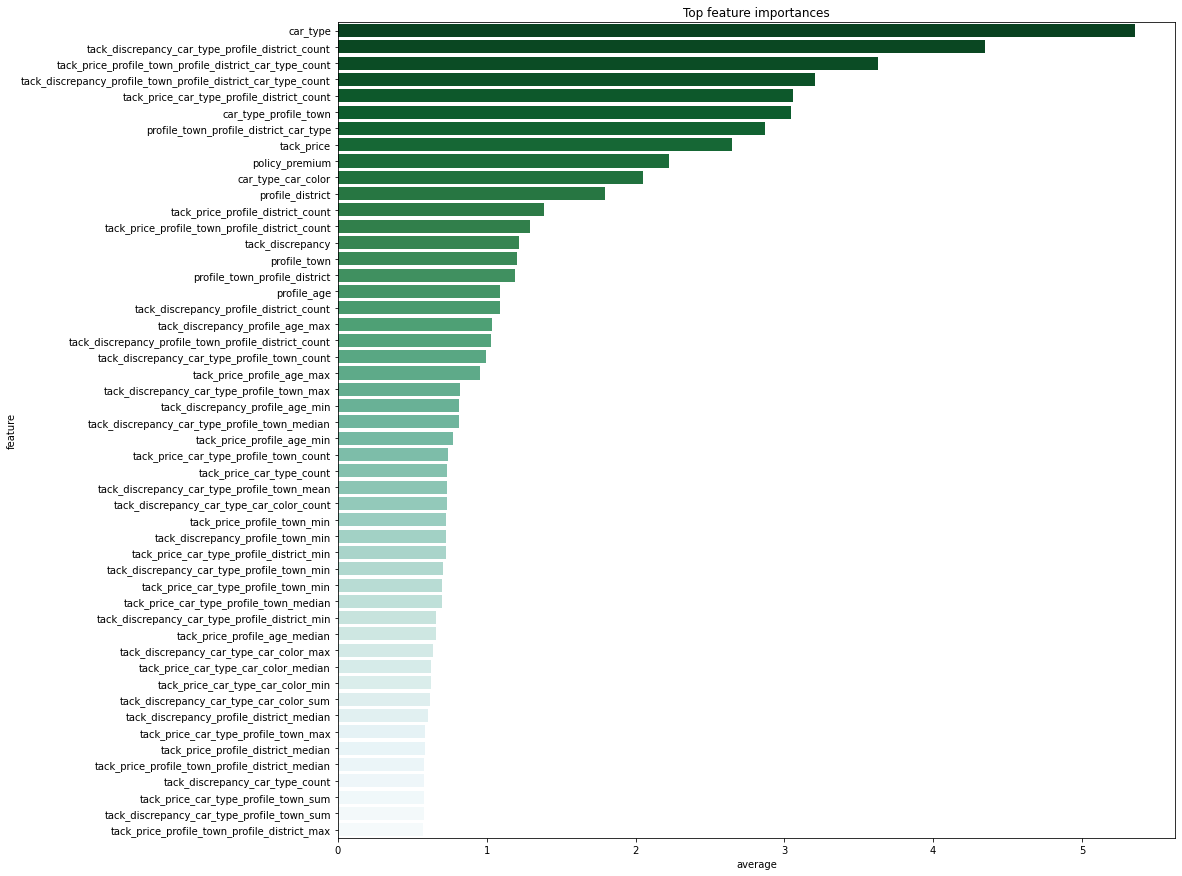

In [115]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

Submission

In [123]:
final_pred = np.average(test_preds, axis=0)

In [127]:
test_id = pd.read_csv('test_hse1.csv')
sub = pd.DataFrame({'id': test_id['id'], 'target': final_pred[:,1]})

In [129]:
sub

,id,target
0,36145,0.443275
1,24679,0.063396
2,8093,0.233711
3,42129,0.278467
4,1323,0.372248
...,...,...
25436,21371,0.193292
25437,2007,0.040972
25438,2727,0.072740
25439,35491,0.027138


<AxesSubplot:>

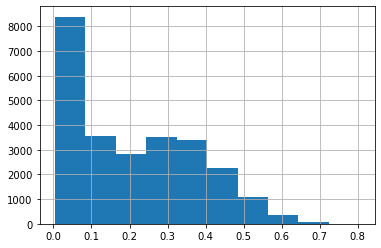

In [130]:
sub["target"].hist()

In [131]:
sub.to_csv('submission_4.csv', index = False)

In [132]:
pd.read_csv('submission_4.csv')

,id,target
0,36145,0.443275
1,24679,0.063396
2,8093,0.233711
3,42129,0.278467
4,1323,0.372248
...,...,...
25436,21371,0.193292
25437,2007,0.040972
25438,2727,0.072740
25439,35491,0.027138


In [159]:
pd.read_csv('sample_submission.csv')

,id,target
0,36145,0
1,24679,0
2,8093,0
3,42129,0
4,1323,0
...,...,...
25436,21371,0
25437,2007,0
25438,2727,0
25439,35491,0
